In [1]:
import os
import random
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from fedlab.contrib.dataset.adult import Adult
from fedlab.utils.dataset.partition import AdultPartitioner
from torch.utils.data import DataLoader, Subset

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"{device} is available")

mps is available


In [3]:
# Define TabularTransform class for data preprocessing
class TabularTransform:
    def __init__(self, noise_std=0.01, feature_scaling=True):
        self.noise_std = noise_std
        self.feature_scaling = feature_scaling

    def __call__(self, features):
        # Adding random noise to the features
        features = features + np.random.normal(0, self.noise_std, size=features.shape)

        # Scaling features to [0, 1] range
        if self.feature_scaling:
            features = (features - features.min(axis=0)) / (
                features.max(axis=0) - features.min(axis=0) + 1e-8
            )

        return features

In [4]:
class TransformedAdult(Adult):
    def __init__(self, root, train=False, download=True, transform=None):
        super().__init__(root, train, download)
        self.transform = transform

    def __getitem__(self, index):
        # Get the features and target label for the given index
        features, target = self.data[index], self.targets[index]

        # Apply transformation if provided
        if self.transform:
            features = self.transform(features)

        # Return transformed features and target
        return torch.tensor(features, dtype=torch.float32), torch.tensor(
            target, dtype=torch.int64
        )

In [5]:
# Dataset and Partitioner
transform = TabularTransform(noise_std=0.05, feature_scaling=True)

dataset_path = os.path.join("path_to_data", "adult-a9a")
trainset = TransformedAdult(
    dataset_path, train=True, download=True, transform=transform
)
testset = TransformedAdult(
    dataset_path, train=False, download=True, transform=transform
)

Local file path_to_data/adult-a9a/a9a loaded.
Local file path_to_data/adult-a9a/a9a.t loaded.


In [6]:
# Parameters
num_clients = 35
seed = 2021
alpha_values = [0.1, 0.3, 1.0, 5.0, 10.0]

# Generate partitions
partitions = {}
for alpha in alpha_values:
    partitions[f"Dirichlet_alpha_{alpha}"] = AdultPartitioner(
        trainset.targets,
        num_clients=num_clients,
        partition="noniid-labeldir",
        dir_alpha=alpha,
        seed=seed,
    )

In [7]:
class SimpleMLP(torch.nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = torch.nn.Linear(123, 64)  # 123 features in Adult dataset
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 2)  # 2 classes (income >50K or <=50K)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def train_on_worker(model, dataloader, device="cpu"):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Ensure the output and labels batch sizes match
        assert outputs.size(0) == labels.size(
            0
        ), f"Output batch size mismatch: {outputs.size(0)} vs {labels.size(0)}"

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    return {k: v.clone() for k, v in model.state_dict().items()}

In [9]:
def aggregate_updates(updates):
    return {
        k: torch.mean(torch.stack([u[k] for u in updates]), dim=0) for k in updates[0]
    }


def full_trim(update, fraction):
    for key, param in update.items():
        k = int(param.numel() * fraction)
        flat = param.view(-1)
        flat[torch.topk(flat.abs(), k=k, largest=False).indices] = 0
        param.copy_(flat.view_as(param))
    return update

In [10]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [11]:
# Running simulations
attack_fraction = 0.4
results = []
Epochs = 50
epoch_results = {alpha: {"Normal": [], "Attack": []} for alpha in alpha_values}

for alpha in alpha_values:
    print(f"Running simulations for alpha = {alpha}...")

    partitioner = partitions[f"Dirichlet_alpha_{alpha}"]
    client_indices = partitioner.client_dict

    workers = {
        i: DataLoader(
            Subset(trainset, indices), batch_size=32, shuffle=True, num_workers=0
        )
        for i, indices in client_indices.items()
    }

    test_loader = DataLoader(testset, batch_size=32, shuffle=False)

    normal_accuracies = []
    attack_accuracies = []

    for attack in [False, True]:
        mode = "Attack" if attack else "No Attack"
        print(f"  Running mode: {mode}")
        model = SimpleMLP()
        epoch_accuracies = []

        for _ in range(Epochs):
            updates = []
            for i, loader in workers.items():
                local_update = train_on_worker(model, loader, device)
                if attack and random.random() < attack_fraction:
                    local_update = full_trim(local_update, 0.6)
                updates.append(local_update)

            aggregated_update = aggregate_updates(updates)
            model.load_state_dict(aggregated_update)
            accE = evaluate_model(model, test_loader, device)
            epoch_accuracies.append(accE)

        acc = evaluate_model(model, test_loader, device)
        print(f"    Accuracy: {acc:.4f}")
        if attack:
            attack_accuracies.append(acc)
            epoch_results[alpha]["Attack"] = epoch_accuracies
        else:
            normal_accuracies.append(acc)
            epoch_results[alpha]["Normal"] = epoch_accuracies

    alpha_value = alpha if isinstance(alpha, float) else alpha.split("_")[2]
    results.append(
        {
            "Alpha": alpha_value,
            "Normal Accuracy": np.mean(normal_accuracies),
            "Attack Accuracy": np.mean(attack_accuracies),
        }
    )

Running simulations for alpha = 0.1...
  Running mode: No Attack
    Accuracy: 84.0919
  Running mode: Attack
    Accuracy: 83.3671
Running simulations for alpha = 0.3...
  Running mode: No Attack
    Accuracy: 84.4973
  Running mode: Attack
    Accuracy: 84.3007
Running simulations for alpha = 1.0...
  Running mode: No Attack
    Accuracy: 84.7614
  Running mode: Attack
    Accuracy: 84.6815
Running simulations for alpha = 5.0...
  Running mode: No Attack
    Accuracy: 84.9518
  Running mode: Attack
    Accuracy: 84.7061
Running simulations for alpha = 10.0...
  Running mode: No Attack
    Accuracy: 84.7614
  Running mode: Attack
    Accuracy: 84.8658


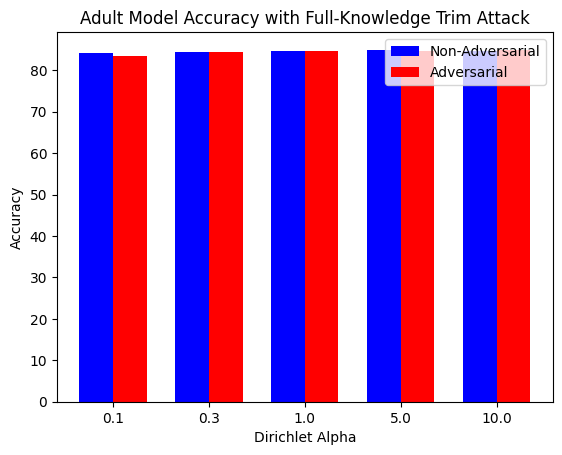

In [12]:
results_df = pd.DataFrame(results)

bar_width = 0.35
alphas_str = results_df["Alpha"].astype(str)
positions = np.arange(len(alphas_str))

plt.bar(
    positions - bar_width / 2,
    results_df["Normal Accuracy"],
    bar_width,
    label="Non-Adversarial",
    color="b",
)
plt.bar(
    positions + bar_width / 2,
    results_df["Attack Accuracy"],
    bar_width,
    label="Adversarial",
    color="r",
)

plt.xlabel("Dirichlet Alpha")
plt.ylabel("Accuracy")
plt.title("Adult Model Accuracy with Full-Knowledge Trim Attack")
plt.xticks(positions, alphas_str)
plt.legend()

plt.savefig("Adult_FKTA_Results.png")
plt.show()

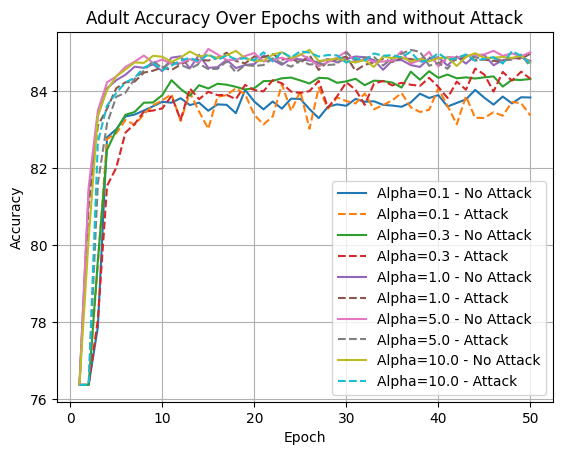

In [14]:
plt.figure()

for alpha in alpha_values:
    epochs = np.arange(1, Epochs + 1)
    plt.plot(
        epochs,
        epoch_results[alpha]["Normal"],
        label=f"Alpha={alpha} - No Attack",
        linestyle="-",
    )
    plt.plot(
        epochs,
        epoch_results[alpha]["Attack"],
        label=f"Alpha={alpha} - Attack",
        linestyle="--",
    )

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Adult Accuracy Over Epochs with and without Attack")
plt.legend()
plt.grid(True)
plt.savefig("Adult_Accuracy_Over_Epochs.png")
plt.show()